In [2]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from lifelines import KaplanMeierFitter
import os 
os.chdir('/data/master/DS175/share/0_Database')
print(os.getcwd())
        
conn = sqlite3.connect('Gliocova.db')
cur = conn.cursor()
query = "SELECT * from TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (BIGTUMOURCOUNT IN (1,2,3,4))"
patients = pd.read_sql(query,conn)
patients = patients.drop_duplicates()

patients.replace(r'^\s*$', np.nan, regex = True, inplace = True)
print(len(patients))


/data/master/DS175/share/0_Database
1335


In [3]:
def survival_per_treatment(df):
        patients=df['PSEUDO_PATIENTID'].tolist()
        ids=tuple(patients)
        tum=pd.read_sql("SELECT * FROM TUM_PAT WHERE PSEUDO_PATIENTID IN {}".format(ids), conn);
        print('Number of these patients in the registrar accroding to pt id:', tum['PSEUDO_PATIENTID'].nunique())
          

        print('Number of brain tumour pts in the cancer registry:', tum['PSEUDO_PATIENTID'].nunique())
        tum['INTERVAL_DIAG_TO_VS'].replace('', np.nan, inplace=True)
        tum.dropna(subset=['INTERVAL_DIAG_TO_VS'], inplace=True)
        tum['INTERVAL_DIAG_TO_VS']=tum['INTERVAL_DIAG_TO_VS'].astype(int)
        death=('D')

        tum=tum.query('VITALSTATUS in "D"')

        print('Number of deceased patients in the cancer registry:', tum['PSEUDO_PATIENTID'].nunique())
        print('DEATH DISTRIBUTION:', tum['INTERVAL_DIAG_TO_VS'].describe())

In [4]:
# chemo

chemo_oligo = pd.read_sql("SELECT * FROM SACT WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (BIGTUMOURCOUNT IN (1,2,3,4)));",conn)
print('Total number of patients with oligodendro in SACT table:', chemo_oligo['PSEUDO_PATIENTID'].nunique())
survival_per_treatment(chemo_oligo)

# so survival rate for patients under chemotherapy == (784-150)/784 == 80.87%
# number of patients who choose chemo == 58.73%


Total number of patients with oligodendro in SACT table: 784
Number of these patients in the registrar accroding to pt id: 784
Number of brain tumour pts in the cancer registry: 784
Number of deceased patients in the cancer registry: 150
DEATH DISTRIBUTION: count     150.000000
mean      871.326667
std       553.011869
min       100.000000
25%       447.500000
50%       743.500000
75%      1191.000000
max      2350.000000
Name: INTERVAL_DIAG_TO_VS, dtype: float64


In [5]:
# radio

radio_oligo = pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (BIGTUMOURCOUNT IN (1,2,3,4)));",conn)
print('Total number of patients with oligodendro in RTDS table:', radio_oligo['PSEUDO_PATIENTID'].nunique())


radio_oligo['PRIMARYDIAGNOSISICD']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str)
radio_oligo['PRIMARYDIAGNOSISICD']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# selecting patients with oligo and treated to primary site: cerebral menninges, spinal menings, cerebrum, temporal lobe, etc
primarydiag=('C70', 'C71', 'C72')
rtds=radio_oligo.query('PRIMARYDIAGNOSISICD in @primarydiag')

site=('P', 'PR')
rtds_final=rtds.query('RTTREATMENTREGION in @site')
survival_per_treatment(rtds_final)
print('Number of patients treated to the primary site (or PR):', rtds_final['PSEUDO_PATIENTID'].nunique())

# 864/1335 = 64.72% patients choose radio

Total number of patients with oligodendro in RTDS table: 864
Number of these patients in the registrar accroding to pt id: 809
Number of brain tumour pts in the cancer registry: 809
Number of deceased patients in the cancer registry: 195
DEATH DISTRIBUTION: count     195.000000
mean      835.353846
std       569.225376
min        68.000000
25%       388.500000
50%       695.000000
75%      1197.500000
max      2416.000000
Name: INTERVAL_DIAG_TO_VS, dtype: float64
Number of patients treated to the primary site (or PR): 809


In [6]:
# surgery, BIOPSY IS INCLUDED
############################################# Looking at surgery ###############################################
surgery=('A012', 'A013', 'A018', 'A019', 'A021', 'A022', 'A023', 'A024', 'A025', 'A026', 'A027', 'A028', 
         'A029', 'A073', 'A078', 'A108', 'A118', 'A168', 'A171', 'A208', 'A291', 'A293', 'A295', 'A298',
         'A381', 'A382', 'A383', 'A384', 'A385', 'A386', 'A388', 'A389', 'A428', 'A431', 'A432', 'A438',
         'A441', 'A442', 'A443', 'A444', 'A445', 'A448', 'A449', 'A511', 'A518', 'A571', 'A599', 'A611', 
         'B012', 'B068', 'C021', 'E158', 'T962', 'V031', 'V038', 'V039', 'V051', 'V058', 'V431', 'V433', 
         'V498', 'V499', 'Y059', 'Y068', 'Y069', 'Y461', 'Y463', 'Y464', 'Y465', 'Y467', 'Y468', 'Y469',
         'A041', 'A042', 'A043', 'A044', 'A045', 'A046', 'A048', 'A049', 'A081', 'A082', 'A083', 'A084', 
         'A085', 'A086', 'A088', 'A089', 'A104', 'A105', 'A181', 'A188', 'A363', 'A422', 'A454', 'A456', 
         'A481', 'A482', 'A513', 'A578', 'A731', 'B042', 'T968', 'V036', 'V052', 'Y201', 'Y202', 'Y208', 
         'Y462', 'Y466', 'Y471', 'Y472', 'Y473', 'Y474', 'Y475', 'Y476', 'Y478', 'Y479', 'Y698')
         
HESIP=pd.read_sql("SELECT * FROM HESAPC WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (BIGTUMOURCOUNT IN (1,2,3,4)));",conn)


In [7]:
HESIP['id']=HESIP.index
# Merging operation, diagnosis and days from diag to operationcolumns from multiple to one 
HESNEW=pd.wide_to_long(HESIP,['OPERTN_'], i="id",j="OP/DAY NUMBER ORIGINAL 1-24")

In [8]:
surgdf=HESNEW.query('OPERTN_ in @surgery')
print('Number of pts undergoing a major resection:', surgdf['PSEUDO_PATIENTID'].nunique())

Number of pts undergoing a major resection: 1254


In [9]:
survival_per_treatment(surgdf)


Number of these patients in the registrar accroding to pt id: 1254
Number of brain tumour pts in the cancer registry: 1254
Number of deceased patients in the cancer registry: 284
DEATH DISTRIBUTION: count     284.000000
mean      740.577465
std       587.900809
min         1.000000
25%       288.000000
50%       577.500000
75%      1057.250000
max      2416.000000
Name: INTERVAL_DIAG_TO_VS, dtype: float64


In [10]:
# Number of patients who undergone all treatment measures
all_treatments=pd.merge((pd.merge(chemo_oligo, radio_oligo, on ='PSEUDO_PATIENTID')), surgdf, on='PSEUDO_PATIENTID')
print(all_treatments['PSEUDO_PATIENTID'].nunique())
# 40.90% patients choose all treatments

652


In [11]:
radio_chemo=pd.merge(chemo_oligo, radio_oligo, on ='PSEUDO_PATIENTID')
print(radio_chemo['PSEUDO_PATIENTID'].nunique())
# 50.04% patients choose radio + chemo therapy

668


In [12]:
sur_chemo=pd.merge(chemo_oligo, surgdf, on ='PSEUDO_PATIENTID')
print(sur_chemo['PSEUDO_PATIENTID'].nunique())
# 46.97% patients choose surgery + chemotherapy

762


In [13]:
radio_sur=pd.merge(surgdf, radio_oligo, on ='PSEUDO_PATIENTID')
print(radio_sur['PSEUDO_PATIENTID'].nunique())
# 52.28% patients choose surgery + radiotherapy

841


In [14]:
# priority discovoery
radio = pd.merge(radio_oligo, patients, on=['PSEUDO_PATIENTID'], how='left')
radio = radio.drop_duplicates(subset='PSEUDO_PATIENTID')
radio.groupby('RADIOTHERAPYPRIORITY')['PSEUDO_PATIENTID'].nunique()

RADIOTHERAPYPRIORITY
      53
D     70
E      3
R    732
U      6
Name: PSEUDO_PATIENTID, dtype: int64

In [15]:
radio.groupby(['SEX','RADIOTHERAPYINTENT'])['PSEUDO_PATIENTID'].nunique()

SEX  RADIOTHERAPYINTENT
1    1                      18
     2                     434
                            11
2    1                      20
     2                     368
     3                       1
                            12
Name: PSEUDO_PATIENTID, dtype: int64

In [16]:
radio.groupby('RTTREATMENTREGION')['PSEUDO_PATIENTID'].nunique()

RTTREATMENTREGION
       30
A       1
M       5
P     826
PR      2
Name: PSEUDO_PATIENTID, dtype: int64

In [17]:
radio.groupby('RADIOTHERAPYBEAMTYPE')['PSEUDO_PATIENTID'].nunique()

RADIOTHERAPYBEAMTYPE
T1    863
T2      1
Name: PSEUDO_PATIENTID, dtype: int64

In [18]:
radio.groupby('RADIOTHERAPYBEAMENERGY')['PSEUDO_PATIENTID'].nunique()

RADIOTHERAPYBEAMENERGY
0.00       5
0.14       1
6.00     827
10.00     17
15.00     13
18.00      1
Name: PSEUDO_PATIENTID, dtype: int64

In [19]:
radio.groupby('NUMBEROFTELETHERAPYFIELDS')['PSEUDO_PATIENTID'].nunique()

NUMBEROFTELETHERAPYFIELDS
1     132
2     318
3      72
4     105
5      70
6      47
7      22
8      26
9       8
10     19
11      6
12     17
13      1
14      6
15      3
16      4
18      2
20      1
21      1
24      1
29      1
30      1
31      1
Name: PSEUDO_PATIENTID, dtype: int64

In [20]:
radio.groupby('RTTREATMENTMODALITY')['PSEUDO_PATIENTID'].nunique()

RTTREATMENTMODALITY
5    862
6      2
Name: PSEUDO_PATIENTID, dtype: int64

In [21]:
radio.groupby('PRESCRIBEDFRACTIONS')['PSEUDO_PATIENTID'].nunique()

PRESCRIBEDFRACTIONS
1       2
3       1
4       1
5       2
6      16
7       2
8       4
9       1
10     13
11      1
13      1
15     17
16      1
17      1
20      6
21      2
22      2
23      2
24      2
25      8
26      1
27     11
28     32
29     12
30    520
31      1
33    199
35      1
40      1
        1
Name: PSEUDO_PATIENTID, dtype: int64

In [22]:
# DOSE AND FRACTION, THE 2 MOST IMPORTANT PARAMETERS
bin = [0, 20, 40, 60, 80]
radio.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
radio['RTPRESCRIBEDDOSE'].replace(r'', np.nan, inplace = True)
radio.dropna(axis=0, subset=['RTPRESCRIBEDDOSE'], inplace=True)

DOSE = pd.cut(radio['RTPRESCRIBEDDOSE'].astype(float).astype(int), bins = bin)
DOSE.value_counts(sort=False).to_frame()


,RTPRESCRIBEDDOSE
"(0, 20]",17
"(20, 40]",54
"(40, 60]",789
"(60, 80]",2


In [1]:
# ACtual Fraction
bin = [0, 10, 20, 30, 80]
radio.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
radio['RTPRESCRIBEDDOSE'].replace(r'', np.nan, inplace = True)
radio.dropna(axis=0, subset=['RTPRESCRIBEDDOSE'], inplace=True)

DOSE = pd.cut(radio['ACTUALFRACTIONS'].astype(float).astype(int), bins = bin)
DOSE.value_counts(sort=False).to_frame()

NameError: name 'radio' is not defined

In [23]:
bin = [0, 20, 40, 60, 80]
radio.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
radio['RTACTUALDOSE'].replace(r'', np.nan, inplace = True)
radio.dropna(axis=0, subset=['RTACTUALDOSE'], inplace=True)

DOSE = pd.cut(radio['RTACTUALDOSE'].astype(float).astype(int), bins = bin)
DOSE.value_counts(sort=False).to_frame()

,RTACTUALDOSE
"(0, 20]",212
"(20, 40]",235
"(40, 60]",104
"(60, 80]",0


In [24]:
bin = [0, 30, 60, 90, 180, 365, 1095, 1825, 10000]
Wait_for_beam = pd.read_sql("SELECT * FROM RTDS WHERE INTERVAL_DIAG_TO_PROCEDURE != '' AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (BIGTUMOURCOUNT IN (1,2,3,4)));",conn)
Wait_for_beam.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
To_beam = pd.cut(Wait_for_beam['INTERVAL_DIAG_TO_PROCEDURE'].astype(int), bins = bin)

To_beam.value_counts(sort=False).to_frame()


,INTERVAL_DIAG_TO_PROCEDURE
"(0, 30]",7
"(30, 60]",183
"(60, 90]",265
"(90, 180]",173
"(180, 365]",66
"(365, 1095]",96
"(1095, 1825]",61
"(1825, 10000]",12


<AxesSubplot: xlabel='NUMBER_OF_CYCLES_PLANNED'>

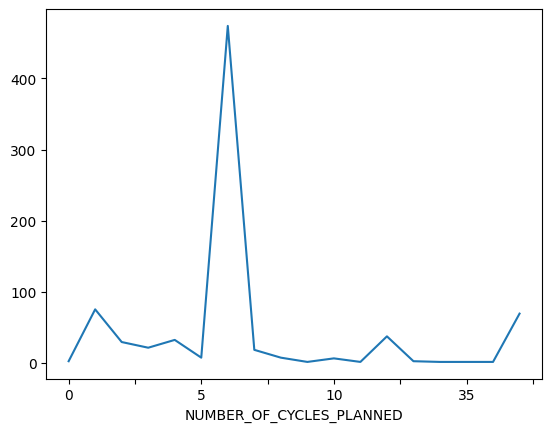

In [25]:
################################################## looking into SACT now ################################################
chemo_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
PLAN_CYCLES = chemo_oligo.groupby('NUMBER_OF_CYCLES_PLANNED')['PSEUDO_PATIENTID'].nunique()
PLAN_CYCLES.plot()

In [26]:
chemo_oligo.groupby('CYCLE_NUMBER')['PSEUDO_PATIENTID'].nunique()

CYCLE_NUMBER
0     13
1    717
2     34
3     11
4      4
5      3
6      2
Name: PSEUDO_PATIENTID, dtype: int64

In [27]:
ac_cycles.plot()

NameError: name 'ac_cycles' is not defined

In [ ]:
bin = [0, 30, 60, 90, 180, 365, 1095, 1825, 10000]
chemo_oligo_temporary = pd.read_sql("SELECT * FROM SACT WHERE INTERVAL_DIAG_FINAL_TREATMENT != '' AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (BIGTUMOURCOUNT IN (1,2,3,4)));",conn)
chemo_oligo_temporary.drop_duplicates(subset=['INTERVAL_DIAG_FINAL_TREATMENT'], inplace=True)
To_Final = pd.cut(chemo_oligo_temporary['INTERVAL_DIAG_FINAL_TREATMENT'].astype(int), bins = bin)
print(len(To_Final))
To_Final.value_counts(sort=False).to_frame()


In [ ]:
chemo_oligo.groupby('INTENT_OF_TREATMENT')['PSEUDO_PATIENTID'].nunique()

In [ ]:
chemo_oligo.groupby('PERF_STAT_START_OF_REG_CLEAN')['PSEUDO_PATIENTID'].nunique()

In [86]:
chemo_oligo.groupby('COMORBIDITY_ADJUSTMENT')['PSEUDO_PATIENTID'].nunique()

COMORBIDITY_ADJUSTMENT
     213
N    508
Y     63
Name: PSEUDO_PATIENTID, dtype: int64

In [87]:
chemo_oligo.groupby('ADMINISTRATION_ROUTE')['PSEUDO_PATIENTID'].nunique()

ADMINISTRATION_ROUTE
0      3
1     98
2    646
5      1
      36
Name: PSEUDO_PATIENTID, dtype: int64

In [88]:
chemo_oligo.groupby('REGIMEN_MOD_STOPPED_EARLY')['PSEUDO_PATIENTID'].nunique()

REGIMEN_MOD_STOPPED_EARLY
     166
N    579
Y     39
Name: PSEUDO_PATIENTID, dtype: int64

In [89]:
chemo_oligo.groupby('REGIMEN_MOD_DOSE_REDUCTION')['PSEUDO_PATIENTID'].nunique()

REGIMEN_MOD_DOSE_REDUCTION
     157
N    495
Y    132
Name: PSEUDO_PATIENTID, dtype: int64

In [90]:
chemo_oligo.groupby('REGIMEN_MOD_TIME_DELAY')['PSEUDO_PATIENTID'].nunique()

REGIMEN_MOD_TIME_DELAY
     339
N    314
Y    131
Name: PSEUDO_PATIENTID, dtype: int64

In [29]:
######################################### sequence part starts here ##################################################
sur = pd.merge(surgdf, df, on=['PSEUDO_PATIENTID'], how='left')
radio_chemo=pd.merge((pd.merge(chemo, radio, on ='PSEUDO_PATIENTID')), df, on='PSEUDO_PATIENTID')
ALL = pd.merge(sur, radio_chemo)
ALL.drop_duplicates(subset='PSEUDO_PATIENTID')





NameError: name 'df' is not defined